# SARIMA

In [70]:
import pandas as pd
import numpy as np
%matplotlib inline

# Load specific forecasting tools
from statsmodels.tsa.statespace.sarimax import SARIMAX

from statsmodels.graphics.tsaplots import plot_acf,plot_pacf # for determining (p,q) orders
from statsmodels.tsa.seasonal import seasonal_decompose      # for ETS Plots
# from pmdarima import auto_arima                              # for determining ARIMA orders

# Ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")

# Load dataset
df = pd.read_csv('Data/co2_mm_mlo.csv', )

In [71]:
df.head()

,year,month,decimal_date,average,interpolated
0,1958,3,1958.208,315.71,315.71
1,1958,4,1958.292,317.45,317.45
2,1958,5,1958.375,317.50,317.50
3,1958,6,1958.458,NaN,317.10
4,1958,7,1958.542,315.86,315.86


In [72]:
df['date']=pd.to_datetime(dict(year=df['year'], month=df['month'], day=1))

In [73]:
df.set_index('date',inplace=True)
df.index.freq = 'MS'
df.head()

,year,month,decimal_date,average,interpolated
date,,,,,
1958-03-01,1958,3,1958.208,315.71,315.71
1958-04-01,1958,4,1958.292,317.45,317.45
1958-05-01,1958,5,1958.375,317.50,317.50
1958-06-01,1958,6,1958.458,NaN,317.10
1958-07-01,1958,7,1958.542,315.86,315.86


plot data

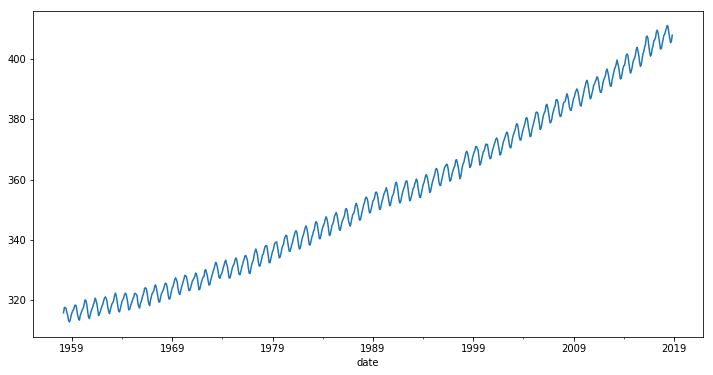

In [13]:
df['interpolated'].plot(figsize = (12,6));

ETS decompostition

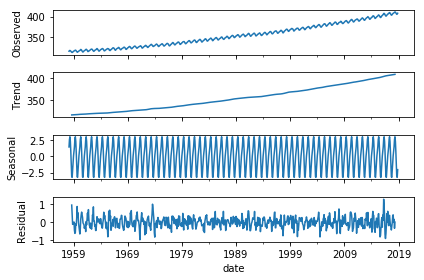

In [12]:
ETS = seasonal_decompose(df['interpolated'], model = 'add')
ETS.plot();

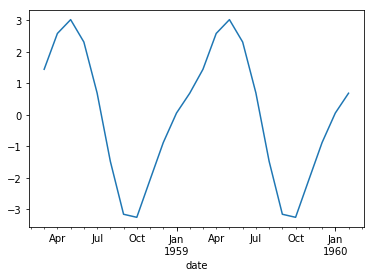

In [23]:
ETS.seasonal[:24].plot();
# log 12 로 주기가 있어보인다

계절성이 있어보인다. 이제 auto_arima를 이용하여 모델을 찾는다.  
본인은 모듈에 문제가 있어서 못했다. ACF, PACF와 grid하게 찾아보자.

In [ ]:
# auto_arima(df['interpolated'],seasonal=True,m=12).summary()

In [14]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

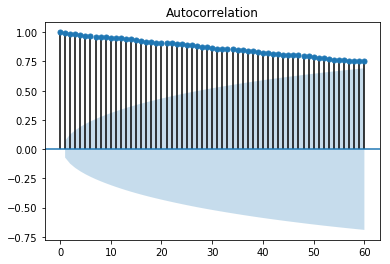

In [17]:
plot_acf(df['interpolated'], lags = 60);

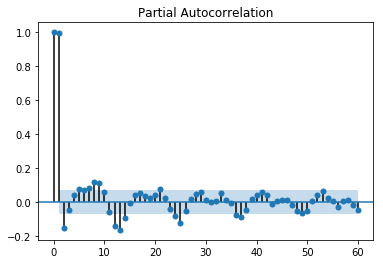

In [18]:
plot_pacf(df['interpolated'], lags = 60);

- 일단 추세가 있으니 차분이 필요해보인다.
- 계절성도 lag12로 있어보인다.
- 모델의 order는 grid로 찾아보자.

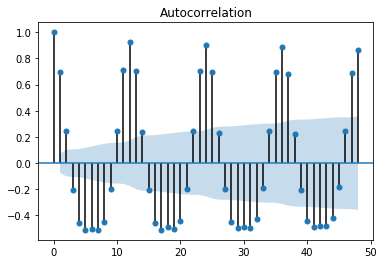

In [36]:
df_diff1 = df['interpolated'].diff()

plot_acf(df_diff1.dropna(), lags = 48);

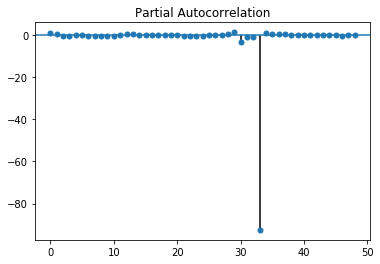

In [38]:
plot_pacf(df_diff1.dropna(), lags = 48);

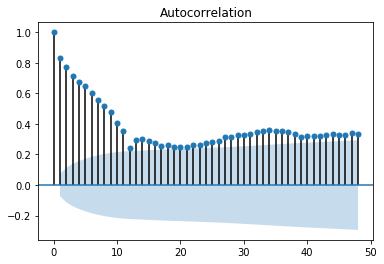

In [37]:
df_diff1_12 = df['interpolated'].diff(12)

plot_acf(df_diff1_12.dropna(), lags = 48);

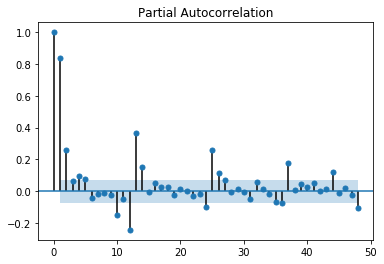

In [39]:
plot_pacf(df_diff1_12.dropna(), lags = 48);

그림으로 판단하기는 확실히 어렵다. 1차 차분, 계절차분 후 정상성 시계열인지 확인해보자.

In [40]:
from statsmodels.tsa.stattools import adfuller

def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val
        
    print(out.to_string())          # .to_string() removes the line "dtype: float64"
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

In [41]:
adf_test(df_diff1_12)

Augmented Dickey-Fuller Test: 
ADF test statistic       -3.622764
p-value                   0.005340
# lags used              13.000000
# observations          703.000000
critical value (1%)      -3.439686
critical value (5%)      -2.865660
critical value (10%)     -2.568964
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


정상이다! 이제 모델을 추정해보자.

In [24]:
len(df)

729

In [25]:
train = df.iloc[:717]
test = df.iloc[717:]

In [46]:
for i in [0,1,2]:
    for j in [0,1,2]:
        model = SARIMAX(train['interpolated'],order=(i,1,j),seasonal_order=(1,0,1,12))
        results = model.fit()
        print('model:', i, j, '(1,0,1,12)')
        print('AIC:', results.aic)
        print()
        
for i in [0,1,2]:
    for j in [0,1,2]:
        model = SARIMAX(train['interpolated'],order=(i,1,j),seasonal_order=(2,0,1,12))
        results = model.fit()
        print('model:', i, j, '(1,0,1,12)')
        print('AIC:', results.aic)
        print()
              
for i in [0,1,2]:
    for j in [0,1,2]:
        model = SARIMAX(train['interpolated'],order=(i,1,j),seasonal_order=(1,0,2,12))
        results = model.fit()
        print('model:', i, j, '(1,0,1,12)')
        print('AIC:', results.aic)
        print()

model: 0 0 (1,0,1,12)
AIC: 491.05535648660646

model: 0 1 (1,0,1,12)
AIC: 418.30842982615354

model: 0 2 (1,0,1,12)
AIC: 417.635700838942

model: 1 0 (1,0,1,12)
AIC: 431.61561240088076

model: 1 1 (1,0,1,12)
AIC: 415.9025339829442

model: 1 2 (1,0,1,12)
AIC: 427.7567276569832

model: 2 0 (1,0,1,12)
AIC: 426.78527640567154

model: 2 1 (1,0,1,12)
AIC: 415.88927493128097

model: 2 2 (1,0,1,12)
AIC: 422.6544308811751

model: 0 0 (1,0,1,12)
AIC: 492.67182956717227

model: 0 1 (1,0,1,12)
AIC: 420.2951253089218

model: 0 2 (1,0,1,12)
AIC: 419.49896539654753

model: 1 0 (1,0,1,12)
AIC: 603.7429033920007

model: 1 1 (1,0,1,12)
AIC: 418.0948648065838

model: 1 2 (1,0,1,12)
AIC: 425.35578806211856

model: 2 0 (1,0,1,12)
AIC: 428.7832381448894

model: 2 1 (1,0,1,12)
AIC: 418.469081662442

model: 2 2 (1,0,1,12)
AIC: 428.84968971647606

model: 0 0 (1,0,1,12)
AIC: 492.6596175620788

model: 0 1 (1,0,1,12)
AIC: 420.2964305366168

model: 0 2 (1,0,1,12)
AIC: 419.499005008978

model: 1 0 (1,0,1,12)
AIC: 4

In [47]:
model = SARIMAX(train['interpolated'],order=(1,1,1),seasonal_order=(1,0,1,12))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                       interpolated   No. Observations:                  717
Model:             SARIMAX(1, 1, 1)x(1, 0, 1, 12)   Log Likelihood                -202.951
Date:                            Wed, 10 Jul 2019   AIC                            415.903
Time:                                    22:52:39   BIC                            438.771
Sample:                                03-01-1958   HQIC                           424.733
                                     - 11-01-2017                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2311      0.070      3.314      0.001       0.094       0.368
ma.L1         -0.5775      0.063     -9.108      0.000      -0.702      -0.453
ar.S.L12       0.9997      0.000   3271.879      0.000       0.999       1.000
ma.S.L12      -0.8658      0.023    -38.427      0.000      -0.910      -0.822
sigma2         0.0954      0.005     20.347      0.000       0.086       0.105
===================================================================================
Ljung-Box (Q):                       49.28   Jarque-Bera (JB):                 5.06
Prob(Q):                              0.15   Prob(JB):                         0.08
Heteroskedasticity (H):               1.14   Skew:                             0.02
Prob(H) (two-sided):                  0.32   Kurtosis:                         3.41
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [48]:
# Obtain predicted values
start=len(train)
end=len(train)+len(test)-1

predictions = results.predict(start=start, end=end, 
                              dynamic=False, 
                              typ='levels').rename('SARIMA(0,1,3)(1,0,1,12) Predictions')

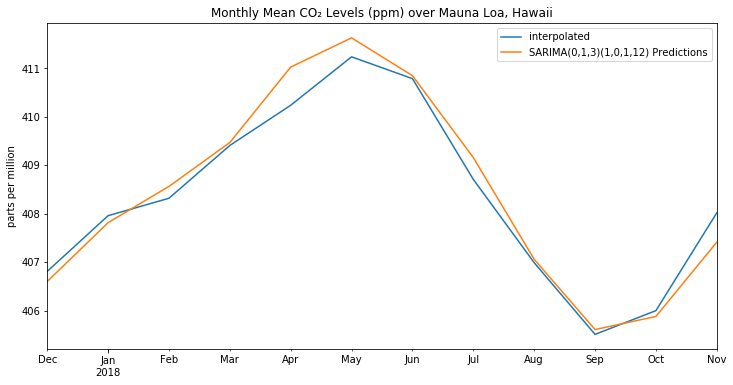

In [49]:
# Plot predictions against known values
title = 'Monthly Mean CO₂ Levels (ppm) over Mauna Loa, Hawaii'
ylabel='parts per million'
xlabel=''

ax = test['interpolated'].plot(legend=True,figsize=(12,6),title=title)
predictions.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

이제 모든 데이터를 써서 Forecast 해보자.

In [50]:
from statsmodels.tools.eval_measures import rmse

error = rmse(test['interpolated'], predictions)
print(f'SARIMA(0,1,3)(1,0,1,12) RMSE Error: {error:11.10}')

SARIMA(0,1,3)(1,0,1,12) RMSE Error: 0.3541735244


In [74]:
model = SARIMAX(df['interpolated'],order=(0,1,3),seasonal_order=(1,0,1,12))
results = model.fit()
fcast = results.predict(len(df),len(df)+11,typ='levels').rename('SARIMA(0,1,3)(1,0,1,12) Forecast')

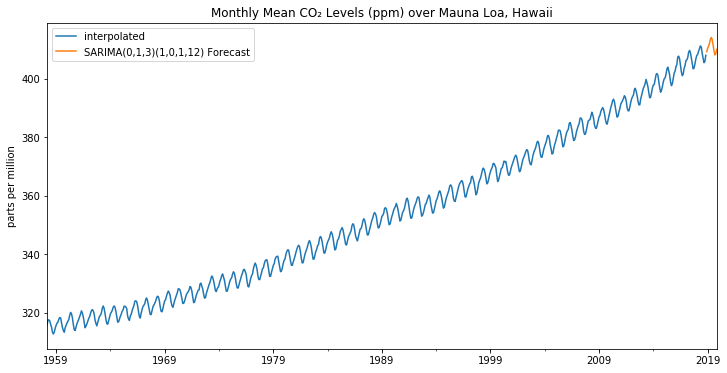

In [52]:
# Plot predictions against known values
title = 'Monthly Mean CO₂ Levels (ppm) over Mauna Loa, Hawaii'
ylabel='parts per million'
xlabel=''

ax = df['interpolated'].plot(legend=True,figsize=(12,6),title=title)
fcast.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

# SARIMAX
- 외부변수(exogenous)를 추가하여 예측모델링하는 것이다.

In [53]:
import pandas as pd
import numpy as np
%matplotlib inline

# Load specific forecasting tools
from statsmodels.tsa.statespace.sarimax import SARIMAX

from statsmodels.graphics.tsaplots import plot_acf,plot_pacf # for determining (p,q) orders
from statsmodels.tsa.seasonal import seasonal_decompose      # for ETS Plots
# from pmdarima import auto_arima                              # for determining ARIMA orders

# Ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")

# Load dataset
df = pd.read_csv('Data/RestaurantVisitors.csv',index_col='date',parse_dates=True)
df.index.freq = 'D'

레스토랑 방문에 holiday를 추가해서 분석하고자 한다.

In [54]:
df.head()

,weekday,holiday,holiday_name,rest1,rest2,rest3,rest4,total
date,,,,,,,,
2016-01-01,Friday,1,New Year's Day,65.0,25.0,67.0,139.0,296.0
2016-01-02,Saturday,0,na,24.0,39.0,43.0,85.0,191.0
2016-01-03,Sunday,0,na,24.0,31.0,66.0,81.0,202.0
2016-01-04,Monday,0,na,23.0,18.0,32.0,32.0,105.0
2016-01-05,Tuesday,0,na,2.0,15.0,38.0,43.0,98.0


In [55]:
df1 = df.dropna()
# Change the dtype of selected columns
cols = ['rest1','rest2','rest3','rest4','total']
for col in cols:
    df1[col] = df1[col].astype(int)
df1.head()

,weekday,holiday,holiday_name,rest1,rest2,rest3,rest4,total
date,,,,,,,,
2016-01-01,Friday,1,New Year's Day,65,25,67,139,296
2016-01-02,Saturday,0,na,24,39,43,85,191
2016-01-03,Sunday,0,na,24,31,66,81,202
2016-01-04,Monday,0,na,23,18,32,32,105
2016-01-05,Tuesday,0,na,2,15,38,43,98


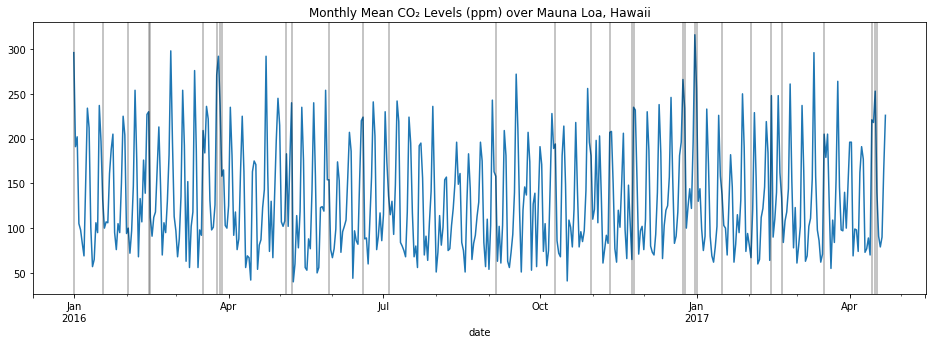

In [58]:
ax = df1['total'].plot(figsize=(16,5),title=title)

for x in df1.query('holiday==1').index:       # for days where holiday == 1
    ax.axvline(x=x, color='k', alpha = 0.3);  # add a semi-transparent grey line

주기는 아마 일주일 lag7일 것 같다. ACF PACF는 생략.

In [59]:
# 정상성
adf_test(df1['total'])

Augmented Dickey-Fuller Test: 
ADF test statistic       -5.592497
p-value                   0.000001
# lags used              18.000000
# observations          459.000000
critical value (1%)      -3.444677
critical value (5%)      -2.867857
critical value (10%)     -2.570135
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


In [60]:
# train / test
train = df1.iloc[:436]
test = df1.iloc[436:]

In [63]:
# ValueError: non-invertible starting MA parameters found 이런 에러가 나오면
# enforce_invertibility = False 을 넣어준다
#아래는 auto로 찾은것
model = SARIMAX(train['total'],
                exog=train['holiday'],
                order=(1,0,0),seasonal_order=(2,0,0,7))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                
=========================================================================================
Dep. Variable:                             total   No. Observations:                  436
Model:             SARIMAX(1, 0, 0)x(2, 0, 0, 7)   Log Likelihood               -2158.482
Date:                           Wed, 10 Jul 2019   AIC                           4326.963
Time:                                   23:04:11   BIC                           4347.352
Sample:                               01-01-2016   HQIC                          4335.010
                                    - 03-11-2017                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
holiday       66.8896      4.241     15.774      0.000      58.578      75.201
ar.L1          0.2145      0.049      4.375      0.000       0.118       0.311
ar.S.L7        0.5147      0.042     12.312      0.000       0.433       0.597
ar.S.L14       0.4575      0.042     10.997      0.000       0.376       0.539
sigma2      1117.3977     73.302     15.244      0.000     973.729    1261.066
===================================================================================
Ljung-Box (Q):                      100.96   Jarque-Bera (JB):                 1.24
Prob(Q):                              0.00   Prob(JB):                         0.54
Heteroskedasticity (H):               0.91   Skew:                             0.11
Prob(H) (two-sided):                  0.58   Kurtosis:                         3.14
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [64]:
start=len(train)
end=len(train)+len(test)-1
exog_forecast = test[['holiday']]  # requires two brackets to yield a shape of (35,1)
predictions = results.predict(start=start, end=end, 
                              exog=exog_forecast).rename('SARIMAX(1,0,0)(2,0,0,7) Predictions')

# 여기서 에측을 위해서 exog 갑을 미리 알고 있어야한다
# 이 데이터의 경우는 holiday 이므로 알기 쉽다

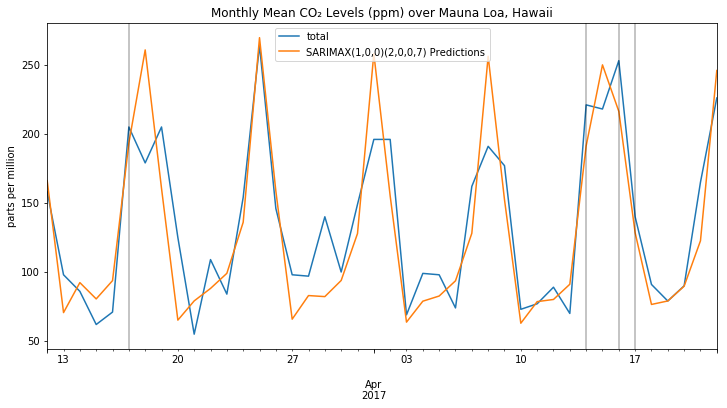

In [65]:
ax = test['total'].plot(legend=True,figsize=(12,6),title=title)
predictions.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)
for x in test.query('holiday==1').index: 
    ax.axvline(x=x, color='k', alpha = 0.3);

validation을 했으니 이제 모든 데이터로 학습시키고 forecast해보자.

In [67]:
model = SARIMAX(df1['total'],exog=df1['holiday'],order=(1,0,0),seasonal_order=(2,0,0,7),enforce_invertibility=False)
results = model.fit()
exog_forecast = df[478:][['holiday']]
fcast = results.predict(len(df1),len(df1)+38,exog=exog_forecast).rename('SARIMAX(1,0,0)(2,0,0,7) Forecast')

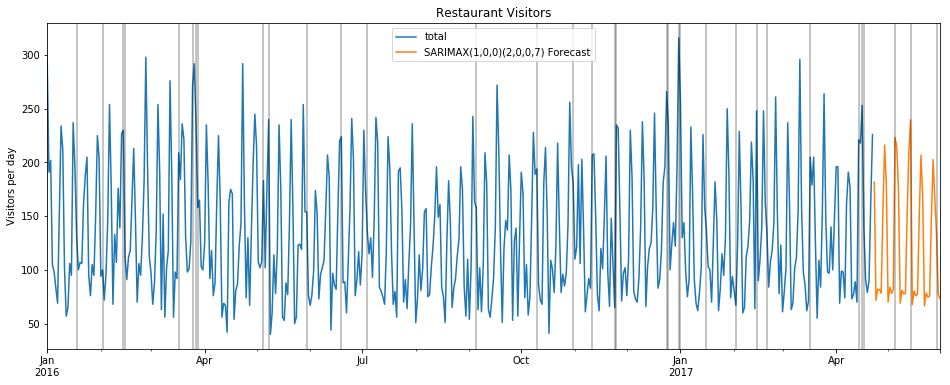

In [68]:
# Plot the forecast alongside historical values
title='Restaurant Visitors'
ylabel='Visitors per day'
xlabel=''

ax = df1['total'].plot(legend=True,figsize=(16,6),title=title)
fcast.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)
for x in df.query('holiday==1').index: 
    ax.axvline(x=x, color='k', alpha = 0.3);

# VAR(MA)
- 다변량 시계열이라고 생각하면 된다.
- 근데 전이함수처럼 Y,X 가 정해진게 아니라 서로 영향을 주는 변수들을 사용.
- 항상 ARIMA 모델보다 좋은 결과를 내는 것은 아니다.

In [76]:
import numpy as np
import pandas as pd
%matplotlib inline

# Load specific forecasting tools
from statsmodels.tsa.statespace.varmax import VARMAX, VARMAXResults
from statsmodels.tsa.stattools import adfuller
# from pmdarima import auto_arima
from statsmodels.tools.eval_measures import rmse

# Ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")

# Load datasets
df = pd.read_csv('Data/M2SLMoneyStock.csv',index_col=0, parse_dates=True)
df.index.freq = 'MS'

sp = pd.read_csv('Data/PCEPersonalSpending.csv',index_col=0, parse_dates=True)
sp.index.freq = 'MS'

In [77]:
df = df.join(sp)
df.head()

,Money,Spending
Date,,
1995-01-01,3492.4,4851.2
1995-02-01,3489.9,4850.8
1995-03-01,3491.1,4885.4
1995-04-01,3499.2,4890.2
1995-05-01,3524.2,4933.1


In [78]:
df = df.dropna()
df.shape

(252, 2)

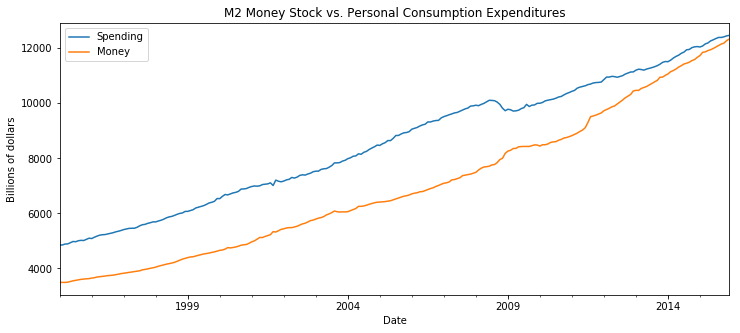

In [80]:
title = 'M2 Money Stock vs. Personal Consumption Expenditures'
ylabel='Billions of dollars'
xlabel=''
ax = df['Spending'].plot(figsize=(12,5),title=title,legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)
df['Money'].plot(legend=True);

In [81]:
# 추세 (trend) 때문에 1차 차분
df_transformed = df.diff().diff()
df_transformed = df_transformed.dropna()
df_transformed.head()

,Money,Spending
Date,,
1995-03-01,3.7,35.0
1995-04-01,6.9,-29.8
1995-05-01,16.9,38.1
1995-06-01,-0.3,1.5
1995-07-01,-6.2,-51.7


In [82]:
# train / test
nobs=12
train, test = df_transformed[0:-nobs], df_transformed[-nobs:]

In [83]:
print(train.shape)
print(test.shape)

(238, 2)
(12, 2)


- VARMAX 는 시간이 오래걸린다
- 차분을 할 수 없기때문에 전처리 후 정상시계열을 넣어야한다.

In [ ]:
# auto 의 기능이 없기 때문에 아래처럼 gird search를 생각하면 된다.

# model = VAR(train)
# for i in [1,2,3,4,5,6,7]:
#     results = model.fit(i)
#     print('Order =', i)
#     print('AIC: ', results.aic)
#     print('BIC: ', results.bic)
#     print()

In [84]:
model = VARMAX(train, order=(1,2))
results = model.fit(maxiter=1000)
results.summary()

Dep. Variable:,"['Money', 'Spending']",No. Observations:,238
Model:,"VARMA(1,2)",Log Likelihood,-2286.321
,+ intercept,AIC,4606.641
Date:,"Wed, 10 Jul 2019",BIC,4665.670
Time:,23:40:02,HQIC,4630.431
Sample:,03-01-1995,,
,- 12-01-2014,,
Covariance Type:,opg,,
Ljung-Box (Q):,"68.32, 28.19",Jarque-Bera (JB):,"554.89, 121.26"
Prob(Q):,"0.00, 0.92",Prob(JB):,"0.00, 0.00"
Heteroskedasticity (H):,"5.61, 2.91",Skew:,"1.34, -0.35"


predict 해보자.

In [85]:
df_forecast = results.forecast(12)
df_forecast

,Money,Spending
2015-01-01,-11.810965,36.259960
2015-02-01,-10.862833,-4.319199
2015-03-01,1.596286,-0.240110
2015-04-01,-1.871427,-0.356186
2015-05-01,1.335958,0.208542
2015-06-01,-0.624488,-0.074877
2015-07-01,0.709655,0.130617
2015-08-01,-0.170508,-0.002636
2015-09-01,0.415250,0.086484
2015-10-01,0.026386,0.027403


근데 이는 우리가 차분한 데이터이므로 원래 데이터로 다시 transform해야된다.

In [88]:
# Add the most recent first difference from the training side of the original dataset to the forecast cumulative sum
df_forecast['Money1d'] = (df['Money'].iloc[-nobs-1]-df['Money'].iloc[-nobs-2]) + df_forecast['Money'].cumsum()

# Now build the forecast values from the first difference set
df_forecast['MoneyForecast'] = df['Money'].iloc[-nobs-1] + df_forecast['Money'].cumsum()

In [89]:
# Add the most recent first difference from the training side of the original dataset to the forecast cumulative sum
df_forecast['Spending1d'] = (df['Spending'].iloc[-nobs-1]-df['Spending'].iloc[-nobs-2]) + df_forecast['Spending'].cumsum()

# Now build the forecast values from the first difference set
df_forecast['SpendingForecast'] = df['Spending'].iloc[-nobs-1] + df_forecast['Spending'].cumsum()

In [90]:
pd.concat([df.iloc[-12:],df_forecast[['MoneyForecast','SpendingForecast']]],axis=1)

,Money,Spending,MoneyForecast,SpendingForecast
Date,,,,
2015-01-01,11733.2,12046.0,11658.289035,12098.259960
2015-02-01,11852.4,12082.4,11647.426202,12093.940761
2015-03-01,11868.8,12158.3,11649.022488,12093.700651
2015-04-01,11916.1,12193.8,11647.151061,12093.344465
2015-05-01,11947.6,12268.1,11648.487019,12093.553007
2015-06-01,11993.1,12308.3,11647.862532,12093.478129
2015-07-01,12045.3,12355.4,11648.572187,12093.608747
2015-08-01,12096.8,12394.0,11648.401678,12093.606111
2015-09-01,12153.8,12392.8,11648.816928,12093.692595
